In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('/media/ssd/test/standardized-datasets/netflow/nf_unsw_nb15_standardized.csv')

In [3]:
# Example if you wanted to keep only certain columns
columns_to_keep = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO',
                   'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']
data = data[columns_to_keep]

In [ ]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,59.166.0.5,1305,149.171.126.8,21,6,1.0,9.0,193.0,1,3,24,0.0,0,Benign
1,59.166.0.5,1305,149.171.126.8,21,6,1.0,261.0,469.0,5,7,24,0.0,0,Benign
2,59.166.0.5,1305,149.171.126.8,21,6,1.0,481.0,750.0,9,11,24,0.0,0,Benign
3,59.166.0.5,1305,149.171.126.8,21,6,1.0,701.0,1054.0,13,15,24,0.0,0,Benign
4,59.166.0.5,1305,149.171.126.8,21,6,1.0,1031.0,1474.0,19,21,24,0.0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390270,59.166.0.4,58663,149.171.126.1,5190,6,0.0,1064.0,2364.0,12,14,27,0.0,0,Benign
2390271,59.166.0.6,60977,149.171.126.4,53,17,0.0,146.0,178.0,2,2,0,0.0,0,Benign
2390272,59.166.0.6,54553,149.171.126.9,80,6,7.0,994.0,8896.0,10,10,26,0.0,0,Benign
2390273,59.166.0.6,55026,149.171.126.5,8248,6,0.0,4014.0,60268.0,68,70,27,0.0,0,Benign


In [5]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [6]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [7]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [8]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [9]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.24.97.245:1305,149.171.126.8:21,6,1.0,9.0,193.0,1,3,24,0.0,0,Benign
1,172.18.233.78:1305,149.171.126.8:21,6,1.0,261.0,469.0,5,7,24,0.0,0,Benign
2,172.17.235.26:1305,149.171.126.8:21,6,1.0,481.0,750.0,9,11,24,0.0,0,Benign
3,172.19.14.249:1305,149.171.126.8:21,6,1.0,701.0,1054.0,13,15,24,0.0,0,Benign
4,172.21.254.101:1305,149.171.126.8:21,6,1.0,1031.0,1474.0,19,21,24,0.0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
2390270,172.29.169.185:58663,149.171.126.1:5190,6,0.0,1064.0,2364.0,12,14,27,0.0,0,Benign
2390271,172.26.234.113:60977,149.171.126.4:53,17,0.0,146.0,178.0,2,2,0,0.0,0,Benign
2390272,172.27.55.49:54553,149.171.126.9:80,6,7.0,994.0,8896.0,10,10,26,0.0,0,Benign
2390273,172.29.143.49:55026,149.171.126.5:8248,6,0.0,4014.0,60268.0,68,70,27,0.0,0,Benign


In [10]:
data.drop(columns=['Label'],inplace = True)

In [11]:
data.rename(columns={"Attack": "label"},inplace = True)

In [12]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [13]:
label = data.label

In [14]:
data.drop(columns=['label'],inplace = True)

In [15]:
scaler = StandardScaler()

In [16]:
data =  pd.concat([data, label], axis=1)

In [17]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.24.97.245:1305,149.171.126.8:21,6,1.0,9.0,193.0,1,3,24,0.0,2
1,172.18.233.78:1305,149.171.126.8:21,6,1.0,261.0,469.0,5,7,24,0.0,2
2,172.17.235.26:1305,149.171.126.8:21,6,1.0,481.0,750.0,9,11,24,0.0,2
3,172.19.14.249:1305,149.171.126.8:21,6,1.0,701.0,1054.0,13,15,24,0.0,2
4,172.21.254.101:1305,149.171.126.8:21,6,1.0,1031.0,1474.0,19,21,24,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...
2390270,172.29.169.185:58663,149.171.126.1:5190,6,0.0,1064.0,2364.0,12,14,27,0.0,2
2390271,172.26.234.113:60977,149.171.126.4:53,17,0.0,146.0,178.0,2,2,0,0.0,2
2390272,172.27.55.49:54553,149.171.126.9:80,6,7.0,994.0,8896.0,10,10,26,0.0,2
2390273,172.29.143.49:55026,149.171.126.5:8248,6,0.0,4014.0,60268.0,68,70,27,0.0,2


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [19]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [20]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [21]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [22]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,h
419626,172.16.229.158:7554,149.171.126.0:6638,0.517209,0.060679,-0.063184,-0.227326,-0.416496,-0.361598,0.265451,-0.253315,2,"[0.5172094689060222, -0.06318407723213725, -0...."
2211951,172.24.124.79:24875,149.171.126.7:21,-0.248948,-0.536876,-0.067618,-0.226251,-0.403474,-0.335544,-0.254089,-0.253315,2,"[-0.24894778922919739, -0.06761799642695143, -..."
1381420,172.17.87.159:40918,149.171.126.1:41712,-0.248948,0.060679,-0.003397,-0.209240,-0.103980,-0.135796,-0.255948,-0.253315,2,"[-0.24894778922919739, -0.0033966721176110133,..."
275782,172.18.62.145:26337,149.171.126.6:6881,-0.248948,0.060679,0.320859,6.903257,5.339008,7.055125,-0.255948,3.947647,2,"[-0.24894778922919739, 0.3208591287865386, 5.3..."
1769163,172.16.38.236:37286,149.171.126.7:35200,-0.248948,0.060679,-0.033510,-0.107619,0.026235,-0.048949,-0.255948,-0.253315,2,"[-0.24894778922919739, -0.033509720500766, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
879374,172.17.125.206:10217,149.171.126.8:6881,-0.248948,0.060679,0.125234,3.195065,2.357084,3.259917,-0.255948,-0.253315,2,"[-0.24894778922919739, 0.12523398720897713, 2...."
321666,172.22.193.89:34828,149.171.126.9:111,0.517209,0.060679,-0.062808,-0.227274,-0.416496,-0.361598,0.265451,-0.253315,2,"[0.5172094689060222, -0.06280805581632262, -0...."
516183,172.21.84.8:15276,149.171.126.9:111,0.517209,0.060679,-0.062808,-0.227221,-0.416496,-0.361598,0.265451,-0.253315,2,"[0.5172094689060222, -0.06280805581632262, -0...."
1493944,172.20.249.161:1475,149.171.126.8:80,-0.248948,0.796664,-0.046952,-0.163062,-0.312324,-0.240012,-0.255948,-0.253315,2,"[-0.24894778922919739, -0.04695248611613904, -..."


In [23]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [24]:
G = G.to_directed()


In [25]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [26]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [27]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [28]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [29]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [30]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [31]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [32]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [33]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 10)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [34]:
from sklearn.utils import class_weight
import numpy as np # Ensure numpy is imported

# Calculate unique classes and labels once
labels_array = G.edata['label'].cpu().numpy()
unique_classes = np.unique(labels_array)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=unique_classes, # Use keyword 'classes='
    y=labels_array          # Use keyword 'y='
)

# Optional: Convert to a dictionary usable by many frameworks
class_weights_dict = dict(zip(unique_classes, class_weights))
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 103.98955873213175, 1: 110.22345191040843, 2: 0.10414133712589199, 3: 41.25226824457594, 4: 7.575803676537173, 5: 10.713914324133956, 6: 14.434023464458248, 7: 18.70533258803801, 8: 167.48668668668668, 9: 1454.9495652173914}


In [35]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [36]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [37]:
G.ndata['h'].device


device(type='cuda', index=0)

In [38]:
G.edata['h'].device


device(type='cuda', index=0)

In [39]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,8000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.7737698554992676
Training acc: 0.7739025354385376
Training acc: 0.7787970900535583
Training acc: 0.78614741563797
Training acc: 0.7961241602897644
Training acc: 0.8083286881446838
Training acc: 0.8954411745071411
Training acc: 0.8712592720985413
Training acc: 0.9585633873939514
Training acc: 0.959266185760498
Training acc: 0.9615448117256165
Training acc: 0.9744022488594055
Training acc: 0.9741395711898804
Training acc: 0.9742376208305359
Training acc: 0.9419260025024414
Training acc: 0.9745714068412781
Training acc: 0.9740062952041626
Training acc: 0.9750865697860718
Training acc: 0.9737783074378967
Training acc: 0.9668015241622925
Training acc: 0.974903404712677
Training acc: 0.9760386347770691
Training acc: 0.9556154012680054
Training acc: 0.9690600633621216
Training acc: 0.9754875898361206
Training acc: 0.9740708470344543
Training acc: 0.9761626720428467
Training acc: 0.9748774170875549
Training acc: 0.8955947756767273
Training acc: 0.9728366732597351
Training acc: 

In [40]:
X_test = encoder.transform(X_test)

In [41]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [42]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
534260,172.29.240.58:56776,149.171.126.2:21,-0.248948,-0.536876,-0.055554,-0.219703,-0.221173,-0.213958,-0.254089,-0.253315,2
899556,172.30.110.199:36091,149.171.126.8:45496,-0.248948,0.060679,-0.033510,-0.102863,0.026235,-0.048949,-0.255948,-0.253315,2
1388723,172.23.2.200:30592,149.171.126.0:80,-0.248948,0.796664,-0.045323,-0.163062,-0.286281,-0.240012,-0.255948,3.947662,2
710340,172.22.133.173:48922,149.171.126.5:21,-0.248948,-0.536876,-0.052107,-0.217892,-0.169087,-0.179219,-0.254089,-0.253315,2
749797,172.20.122.186:44476,149.171.126.5:35425,-0.248948,0.060679,-0.026992,-0.048645,0.130407,0.003159,-0.255948,-0.253315,2
...,...,...,...,...,...,...,...,...,...,...,...
79694,172.28.157.32:61726,149.171.126.0:21911,-0.248948,0.060679,0.004468,0.290579,0.625224,0.350546,-0.255948,-0.253315,2
78342,172.21.13.17:56861,149.171.126.7:21,-0.248948,-0.536876,-0.032742,-0.206517,0.117386,0.037898,-0.220219,-0.253315,2
817024,172.27.96.214:33728,149.171.126.7:21,-0.248948,-0.536876,-0.043239,-0.212941,-0.038872,-0.092373,-0.254089,-0.253315,2
2194933,172.28.18.22:65407,149.171.126.17:179,-0.248948,0.060679,-0.059769,-0.225762,-0.286281,-0.309490,7.429918,-0.253315,5


In [43]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [44]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [45]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [46]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [47]:
G_test = G_test.to('cuda:0')


In [48]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [49]:
print(str(elapsed) + ' seconds')


0.07705394551157951 seconds


In [50]:
test_pred = test_pred.argmax(1)


In [51]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [52]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [53]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

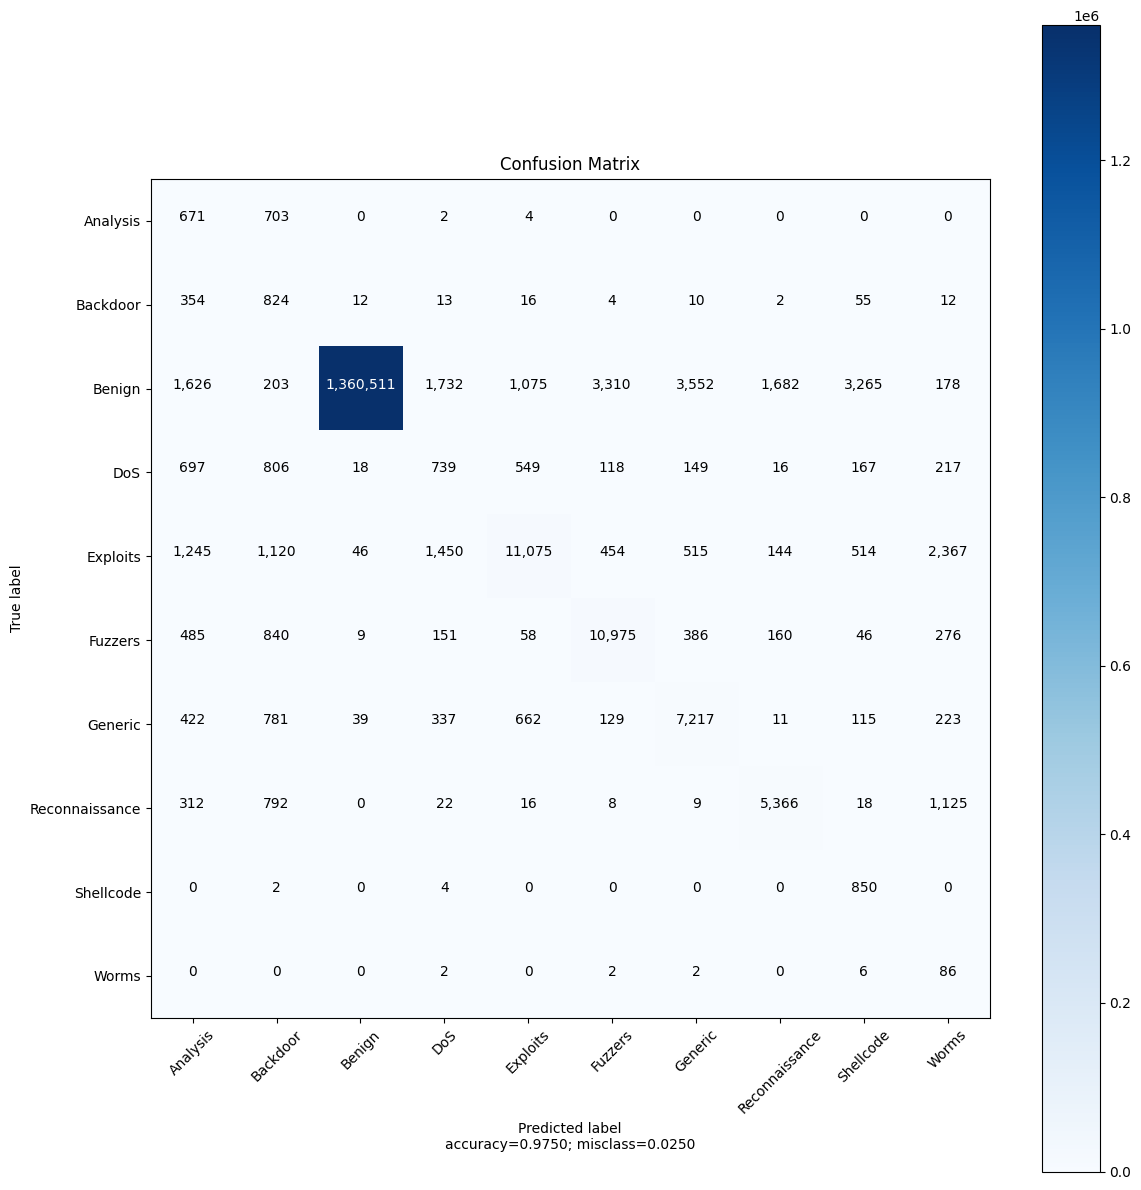

In [54]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")